In [213]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%config InlineBackend.figure_format='retina'

from IPython.display import display, HTML

In [60]:
ffqdc=pd.read_csv('../nhanes-2005-2006/FFQDC_D.csv',index_col=0).drop(columns='FFQ_CODE')
varlook=pd.read_csv('../nhanes-2005-2006/VARLK_D.csv',index_col=0)
foodlook=pd.read_csv('../nhanes-2005-2006/FOODLK_D.csv',index_col=0)

# 1. Compare varlook and foodlook

In [20]:
def findInVarlook(key,show=True):
    if show: print('Varlook')
    ids=[]
    for i,e in enumerate(varlook['VALUE']):
        if key in e.lower():
            if show: print(e)
            ids.append(varlook.loc[i]['FFQ_VAR'])
    return ids

def findInFoodlook(key,show=True):
    if show: print('Foodlook')
    ids=[]
    for i,e in enumerate(foodlook['VALUE']):
        if key in e.lower():
            if show: print(e)
            ids.append(foodlook.loc[i]['FFQ_FOOD'])
    return ids

In [41]:
varlookMilk = findInVarlook('milk',show=False)
foodlookMilk = findInFoodlook('milk',show=False)

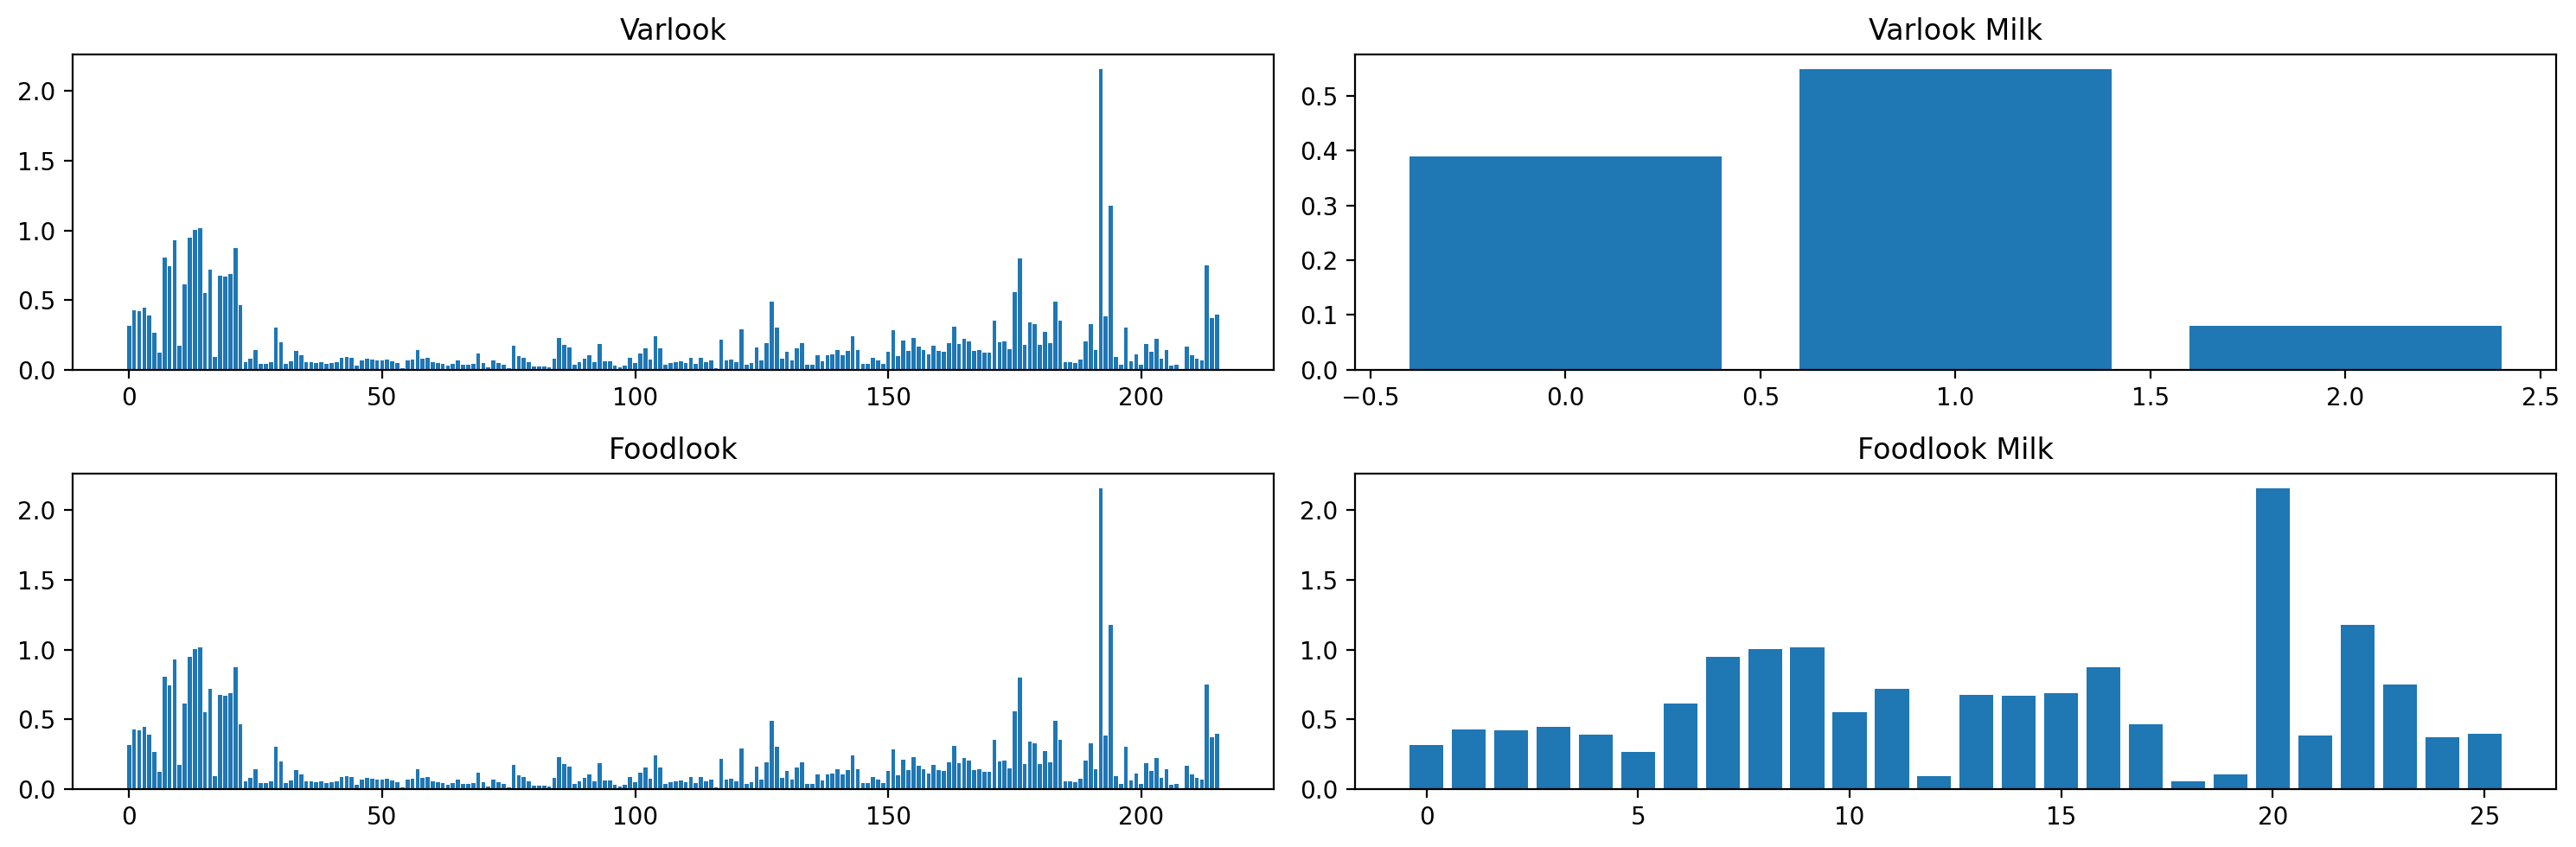

In [39]:
varlookFrequencies=ffqdc.groupby('FFQ_FOOD').mean().drop(columns='SEQN')
varlookMilkFrequencies = varlookFrequencies.loc[varlookMilk]

foodlookFrequencies=ffqdc.groupby('FFQ_FOOD').mean().drop(columns='SEQN')
foodlookMilkFrequencies = foodlookFrequencies.loc[foodlookMilk]

fig,ax=plt.subplots(nrows=2,ncols=2,figsize=(15,5),tight_layout=True)
ax[0,0].set_title('Varlook')
ax[0,0].bar(list(range(len(varlookFrequencies))),varlookFrequencies['FFQ_FREQ'])
ax[0,1].set_title('Varlook Milk')
ax[0,1].bar(list(range(len(varlookMilkFrequencies))),varlookMilkFrequencies['FFQ_FREQ']);

ax[1,0].set_title('Foodlook')
ax[1,0].bar(list(range(len(foodlookFrequencies))),foodlookFrequencies['FFQ_FREQ'])
ax[1,1].set_title('Foodlook Milk')
ax[1,1].bar(list(range(len(foodlookMilkFrequencies))),foodlookMilkFrequencies['FFQ_FREQ']);

# 2. Create new mapping from all unique descriptions

In [247]:
unique_descriptions = ffqdc.groupby(['FFQ_FOOD','FFQ_VAR']).size().reset_index().rename(columns={0:'count'})

varlookDict = varlook.set_index('FFQ_VAR').to_dict()['VALUE']
foodlookDict=foodlook.set_index('FFQ_FOOD').to_dict()['VALUE']

unique_descriptions['FOODLOOK']=unique_descriptions.apply(lambda x: foodlookDict[x['FFQ_FOOD']],axis=1)
unique_descriptions['VARLOOK']=unique_descriptions.apply(lambda x: varlookDict[x['FFQ_VAR']],axis=1)

### i. add seasonal weight

In [338]:
def returnSeasonalWeight(e):
    '''
    Daily frequency for a seasonal variable is the daily frequency during that season.
    
    from https://epi.grants.cancer.gov/dhq2/help/faqs.html
    
    Diet*Calc's default settings for when frequency questions are asked for "in season"
    vs. "rest of year," are 1/4 vs 3/4 of a calendar year. For frequency questions asked
    with the terminology "in summer/winter" vs. "rest of year" the settings are 1/3 vs 2/3
    of the year.
    
    (the only winter/summer variables are soup, soda, beer, oatmeal)
    '''
    
    varlook=e['VARLOOK'].lower()
    
    if 'winter' in varlook: return 1/3
    if 'in summer' in varlook: return 1/3
    if 'in season' in varlook: return 1/4
        
    if 'rest of year' in varlook:
        if 'soda' in varlook or 'soup' in varlook or 'beer' in varlook or 'oatmeal' in varlook:
            return 2/3
        else:
            return 3/4
    
    return 1

unique_descriptions['SEASONAL_WEIGHT']=unique_descriptions.apply(returnSeasonalWeight,axis=1)

### ii. return compiled description

In [346]:
def returnDescription(e):
    
    # 1. remove redundant information (if same information is encoded, return the most specific description)
    
    foodlook_only = list(range(0,79+1))+list(range(88,127+1))+[130]+list(range(135,151+1))+list(range(154,159+1))+list(range(162,193+1))+list(range(202,204+1))+list(range(207,214+1))+list(range(219,221+1))+list(range(224,238+1))
    
    compiled=e['FOODLOOK']
         
    # 2. convert to lowercase
    
    compiled=compiled.lower()
    
    # 3. remove irrelevant information
    
    def removePhrases(string,phrases):
        returnString=string
        for p in phrases:
            returnString=returnString.replace(p,'')
        return returnString
    
    compiled=removePhrases(compiled,['in cereal','in coffee or tea','to drink','in winter','in the winter','in summer','rest of year','in season'])
    
    # 4. format
    compiled=compiled.replace('/',',')
    
    return compiled

unique_descriptions['DESCRIPTION']=unique_descriptions.apply(returnDescription,axis=1)

In [347]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):
    display(unique_descriptions[['DESCRIPTION','SEASONAL_WEIGHT']])

,DESCRIPTION,SEASONAL_WEIGHT
0,"milk, whole",1.000000
1,"milk, 2%",1.000000
2,"milk, 1%",1.000000
3,"milk, nonfat,skim",1.000000
4,"milk, soy,",1.000000
5,"milk, rice,",1.000000
6,"non-dairy crm, powdrd, reg",1.000000
7,"non-dairy crm, powdrd, diet",1.000000
8,"non-dairy crm, liquid, reg",1.000000
9,"non-dairy crm, liquid, diet",1.000000
